<a href="https://colab.research.google.com/github/LittleAri/egg_cards/blob/main/egg_cards_layoutparser_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Egg Card Indexing - Layout Parser Tests

We test out [layout parser](https://layout-parser.github.io/) for detecting boxes in egg cards and extracting text.

### Installs

In [ ]:
!pip install -U layoutparser
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
!pip install layoutparser[ocr]

!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.5 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=11557ee8f31aa2f4fd8631ecb267dae628a5cb09a99514cc5c69fb5794978f5a
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-wr1lfnma/detectron2_a18f6ab572df4684a4ad5d00187039c4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
!git clone https://github.com/Layout-Parser/layout-parser.git

Cloning into 'layout-parser'...
remote: Enumerating objects: 1357, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1357 (delta 325), reused 263 (delta 255), pack-reused 975
Receiving objects: 100% (1357/1357), 62.86 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (738/738), done.
Updating files: 100% (120/120), done.


In [ ]:
!pip install deskew

In [ ]:
!pip install google-cloud-vision==1.0.0

### Imports

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import rotate
from deskew import determine_skew
import layoutparser as lp
from matplotlib import pyplot as plt
import cv2
import matplotlib
%matplotlib inline
import numpy as np
from copy import deepcopy

### Sample Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = 'drive/My Drive/egg_cards/drawer_1/001-0626.jpg'
image = cv2.imread(image_path)

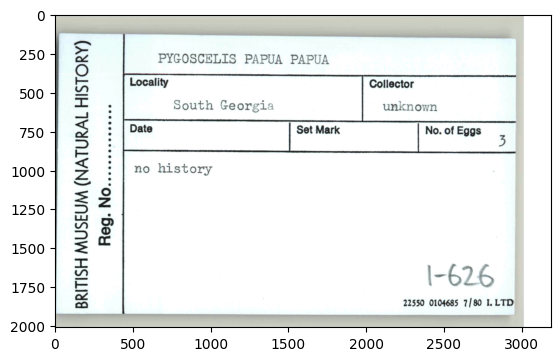

In [ ]:
plt.imshow(image)

### Box Alignment

(Ben's alignment code)

In [ ]:
# https://pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/

def get_angle_point(rect):
    """
    The point the minAreaRect is calculate from is lowest Y

    """

    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Get the largest y (lowest
    bottom_points = box[box[:, 1].argsort()][2:]

    # Get the lowest point (max y - counts from the top)
    min_y_point = bottom_points[np.where(bottom_points[:, 1] == np.max(bottom_points[:, 1]))]

    # If there's two points, x max
    if len(min_y_point) == 2:
        return bottom_points[np.argmax(bottom_points[:, 0])]
    else:
        return min_y_point.squeeze()

In [ ]:
def rotate_image(original_image):
  image = deepcopy(original_image)
  # 1) Threshold image
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(grey, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # 2) Find contour around card:
  contours, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_flat = np.vstack(contours).squeeze()
  rect = cv2.minAreaRect(contours_flat)
  box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
  box = np.int0(box)
  # 3) Get angle axis point:
  point = get_angle_point(rect)
  # 4) Compute rotation matrix:
  center, width_height, angle = rect
  # If the point to which the angle is calculate is the bottom left,
  if point[0] < center[0]:
      angle = angle - 90
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  # 5) Rotate image:
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated

In [ ]:
image = cv2.imread(image_path)
rotated_image = rotate_image(image)

(-0.5, 3187.5, 2007.5, -0.5)

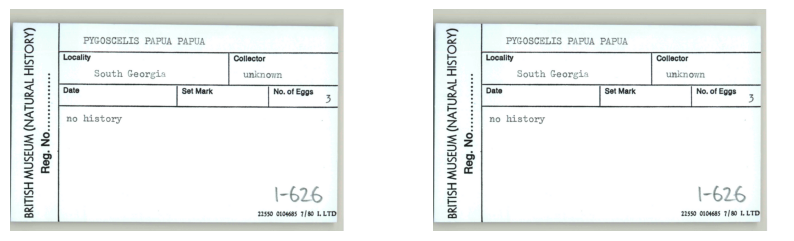

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
ax[1].imshow(rotated_image)
ax[0].axis('off')
ax[1].axis('off')

## Layout Parser

### Tesseract

In [ ]:
import layoutparser as lp

In [ ]:
model = lp.TesseractAgent()

In [ ]:
res = model.detect(rotated_image, return_response=True)

In [ ]:
ocr  = model.gather_data(res, lp.TesseractFeatureType(4))


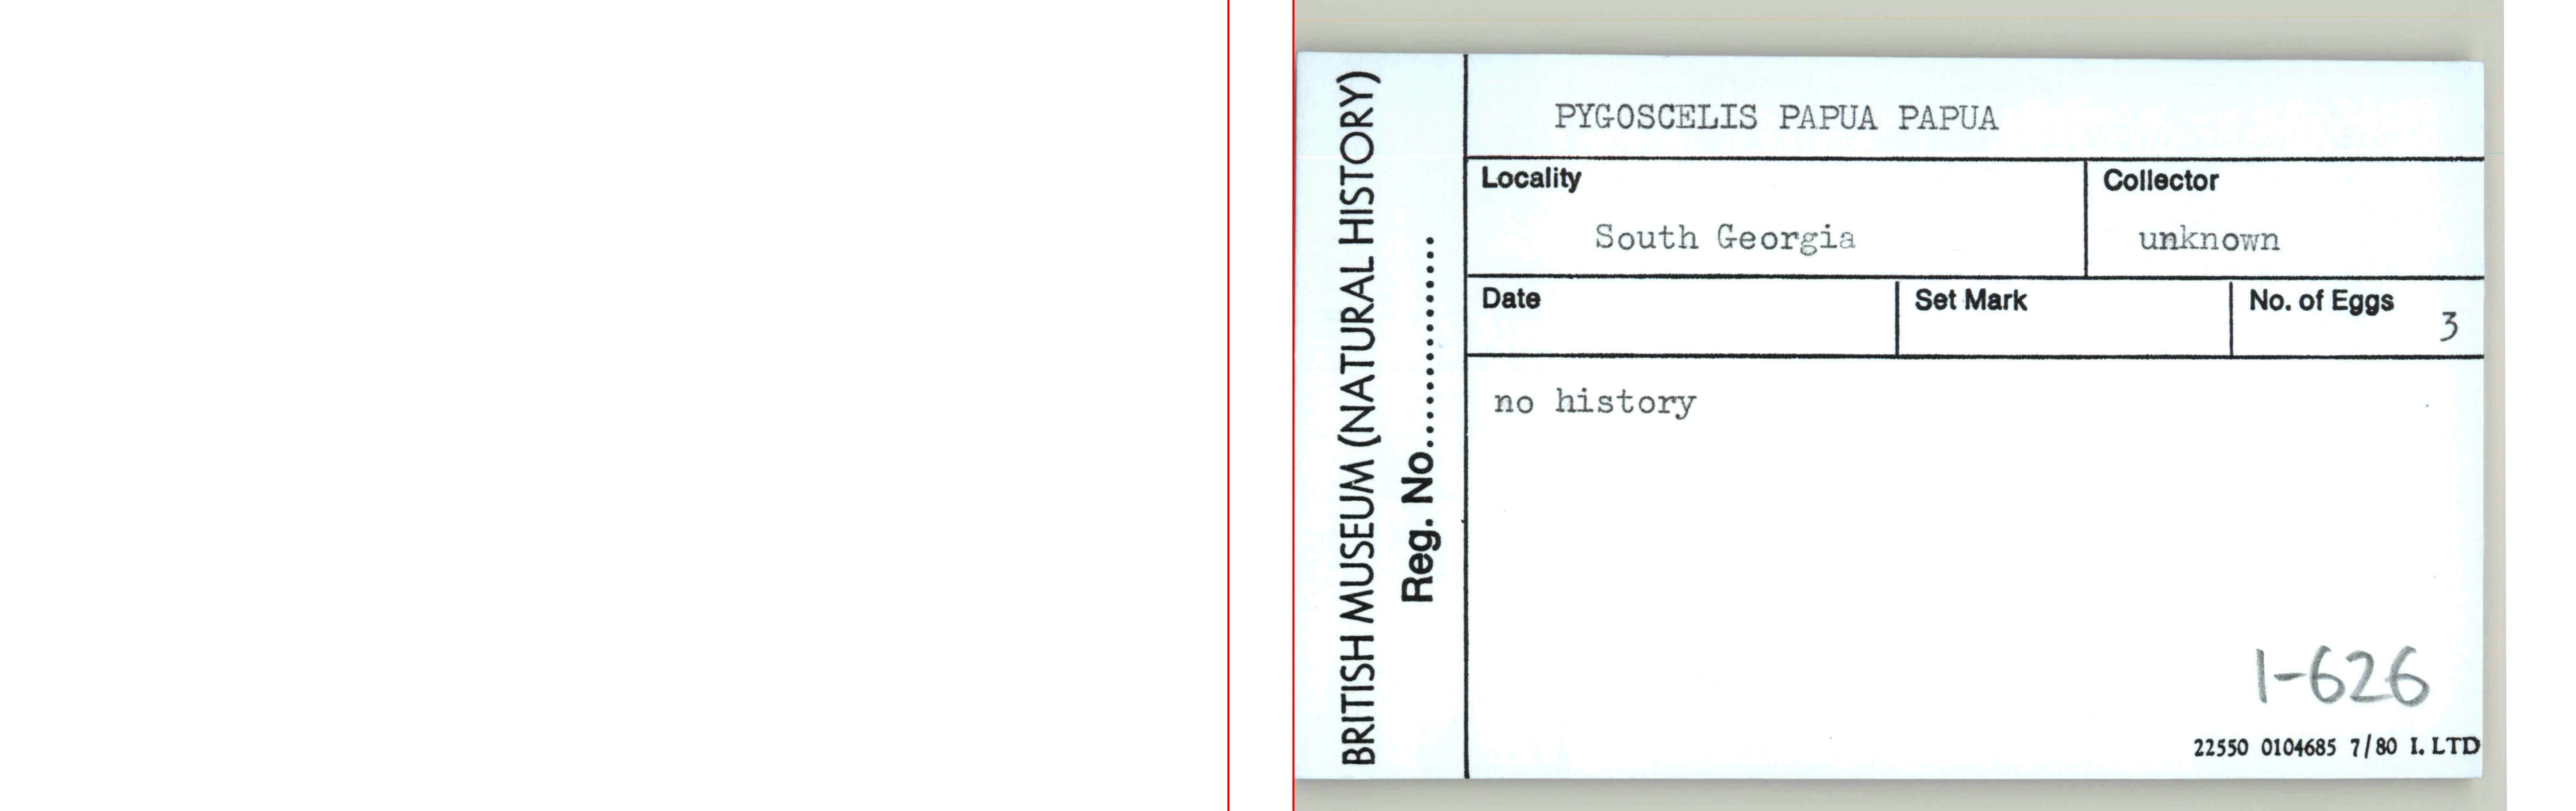

In [ ]:
lp.draw_text(rotated_image, ocr, font_size=20, with_box_on_text=True,
             text_box_width=10)

In [ ]:
print(ocr)

Layout(_blocks=[TextBlock(block=Rectangle(x_1=0, y_1=0, x_2=3188, y_2=2008), text=, id=0, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=2964, y_1=3, x_2=3008, y_2=203), text=, id=1, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=2964, y_1=3, x_2=3007, y_2=99), text=, id=2, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=2964, y_1=3, x_2=3007, y_2=36), text=, id=3, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=2964, y_1=35, x_2=2973, y_2=36), text==, id=4, type=None, parent=None, next=None, score=33.0), TextBlock(block=Rectangle(x_1=2972, y_1=3, x_2=3007, y_2=36), text=ail, id=5, type=None, parent=None, next=None, score=32.0), TextBlock(block=Rectangle(x_1=3006, y_1=67, x_2=3007, y_2=99), text=, id=6, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=3006, y_1=67, x_2=3007, y_2=99), text=|, id=7, type=None, parent=None, next=None, score

### Detectron

In [ ]:
import layoutparser as lp

# PubLayNet
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.81],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
# TableBank
# model = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_50_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
#                                  label_map={0: "Table"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)

#### Original Image

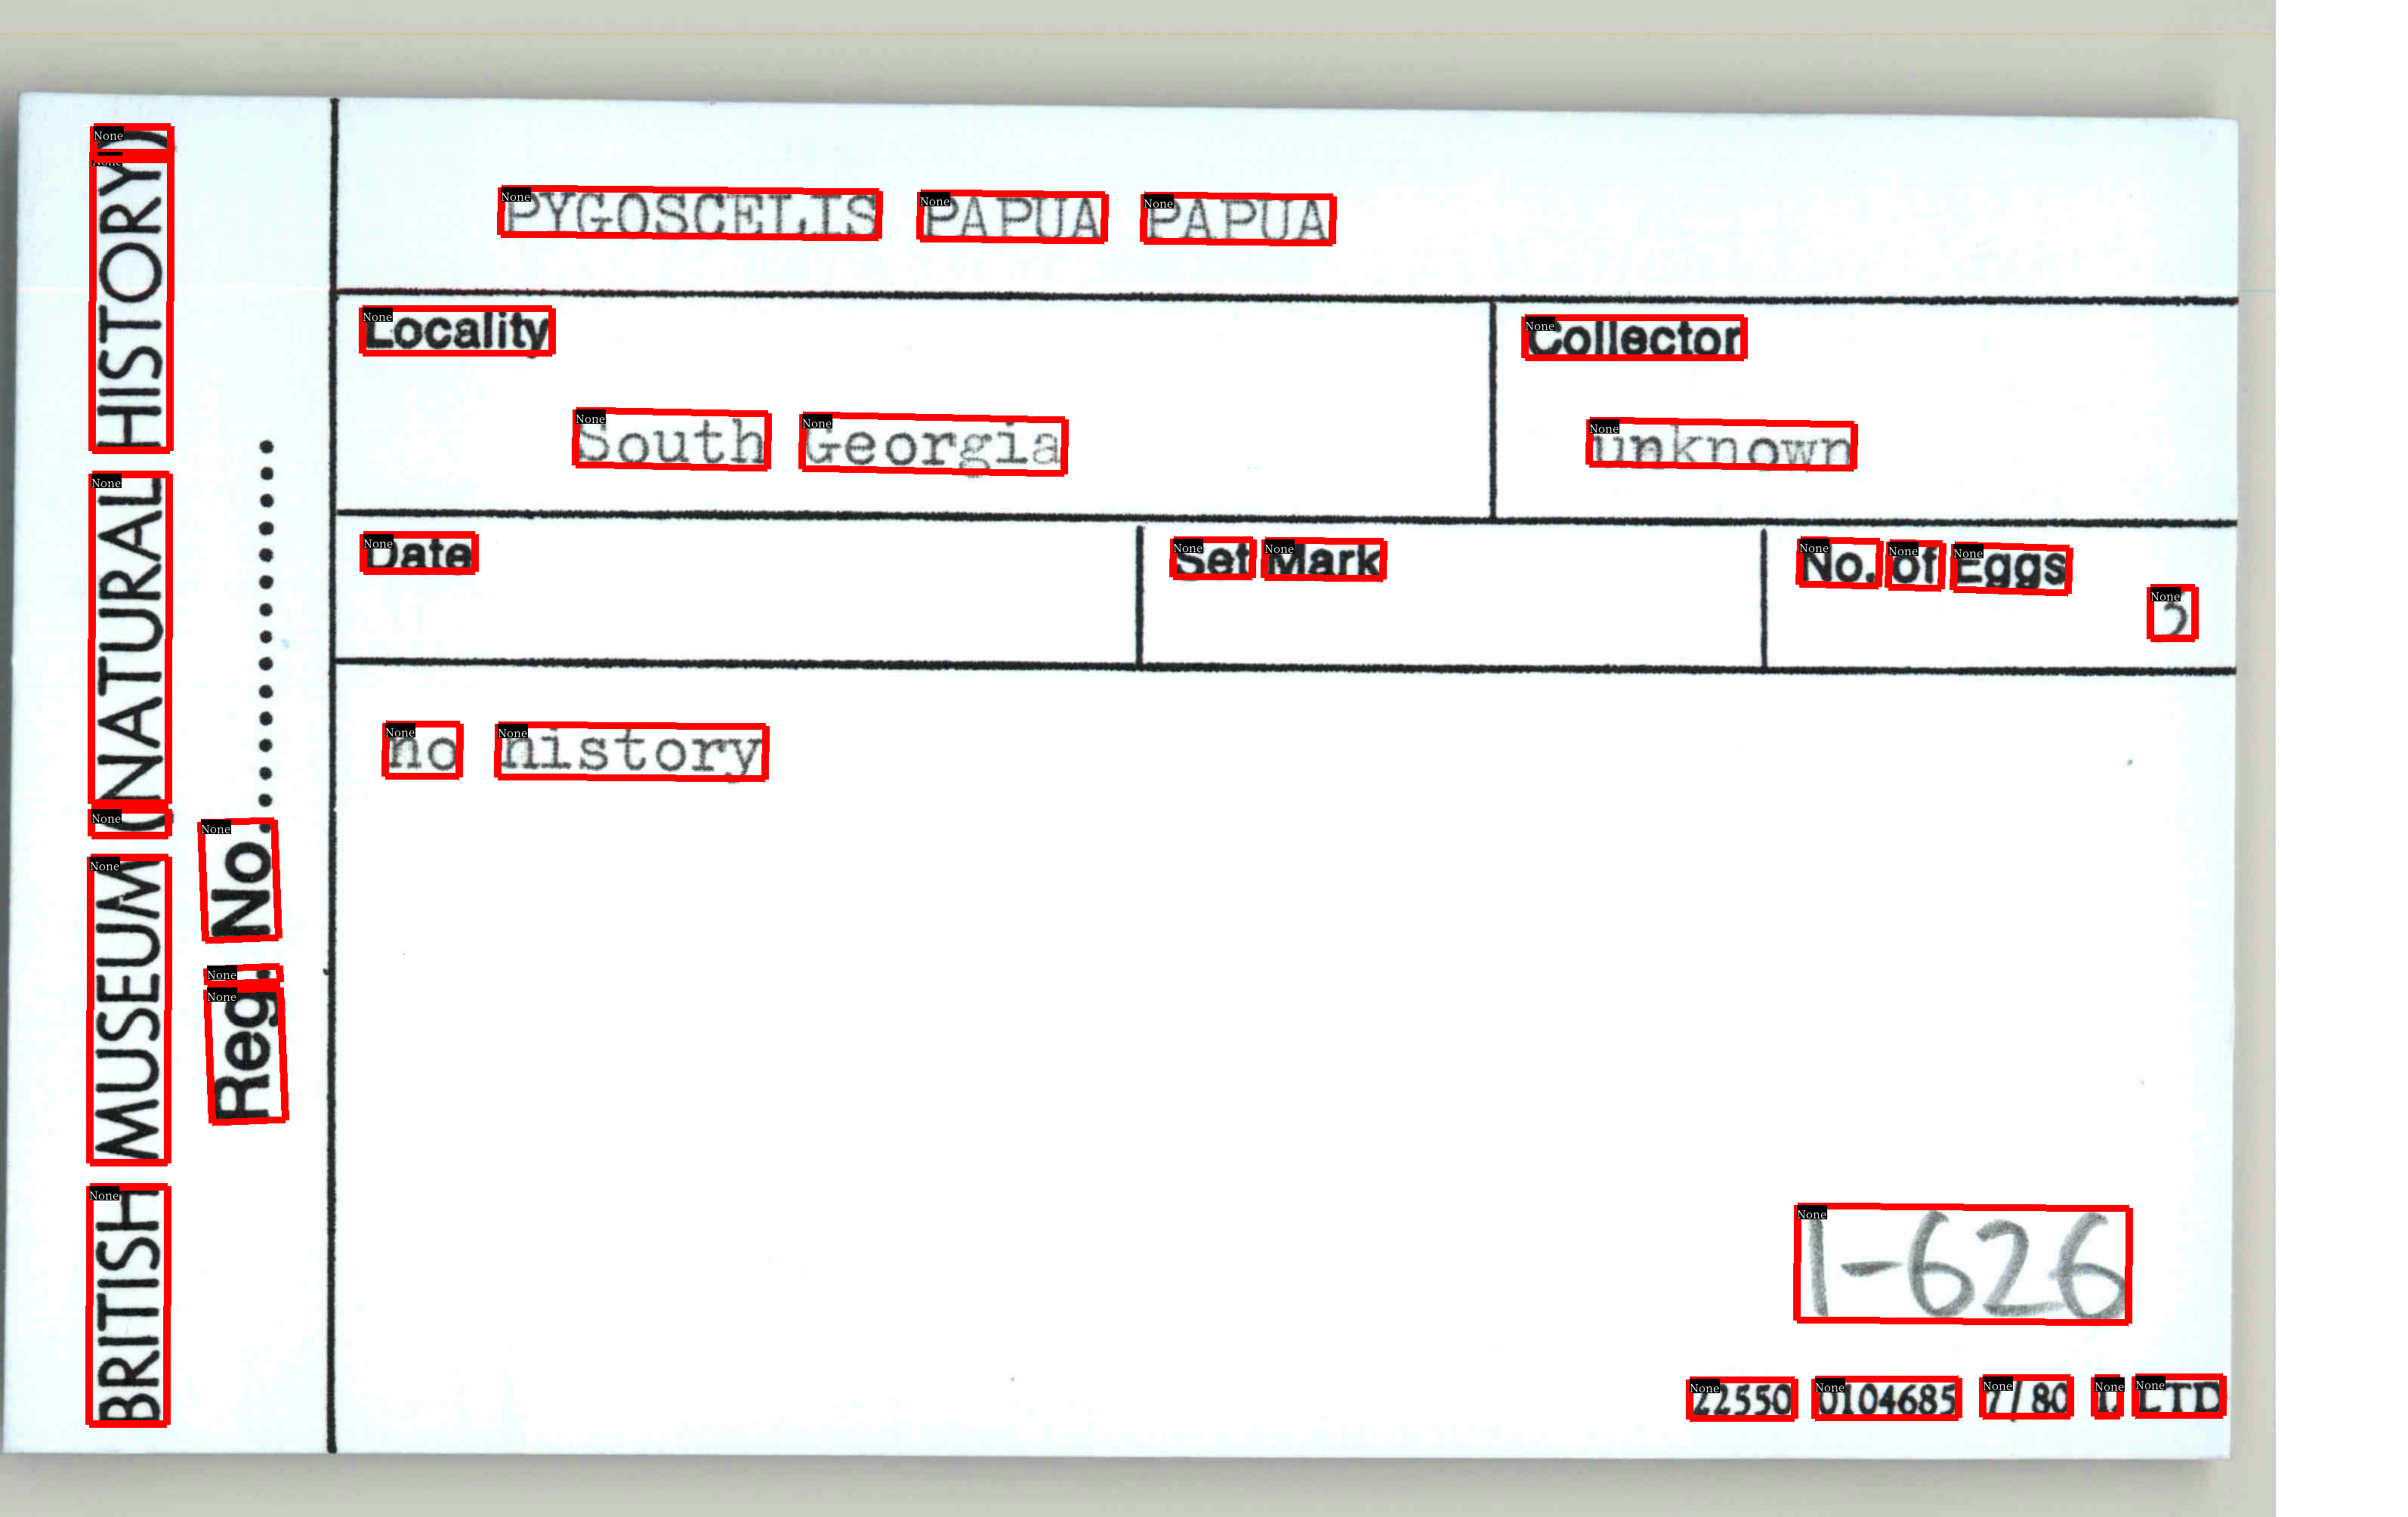

In [ ]:
lp.draw_box(image, layout, box_width=10, color_map={}, show_element_type=True, id_text_color='white', id_text_background_color='black')

#### Rotated Image

In [ ]:
layout = model.detect(rotated_image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)

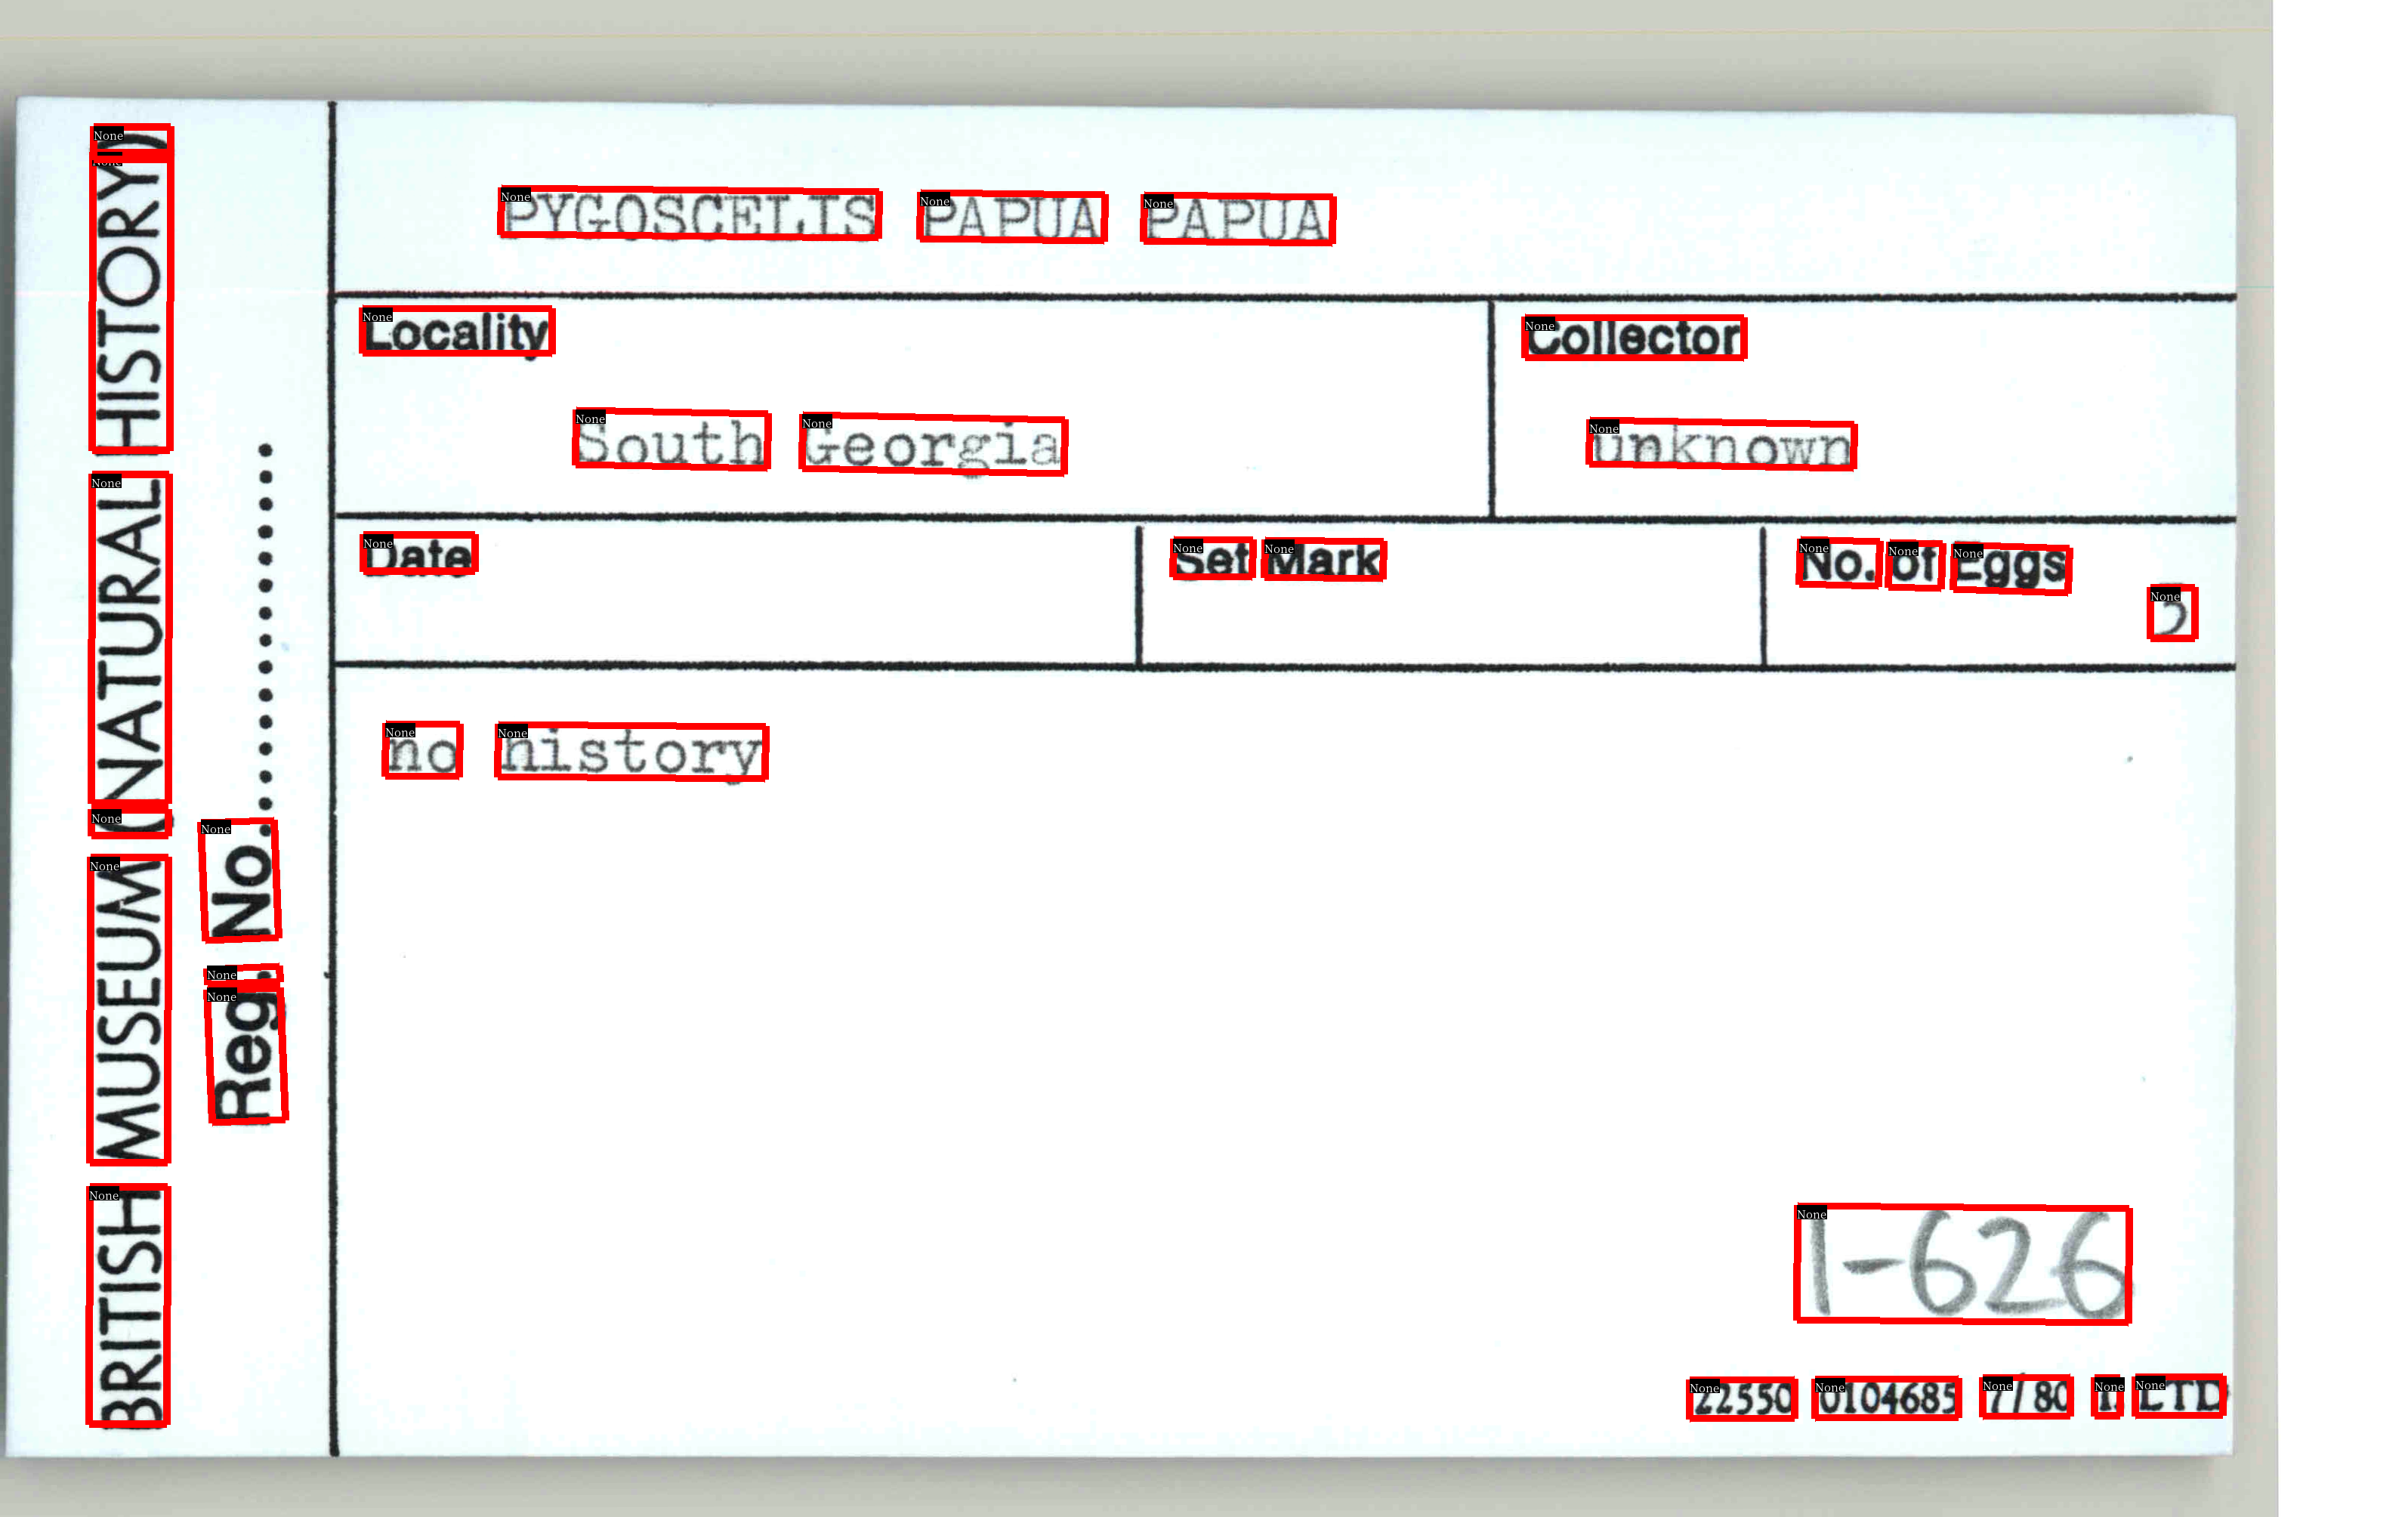

In [ ]:
lp.draw_box(rotated_image, layout, box_width=10, color_map={}, show_element_type=True, id_text_color='white', id_text_background_color='black')

In [ ]:
for l in layout:
  print(l.text)

BRITISH
MUSEUM
(
NATURAL
HISTORY
)
Reg
.
No.
PYGOSCELIS
PAPUA
PAPUA
Locality
Date
South
Georgia
no
history
Set
Mark
Collector
unknown
No.
of
Eggs
3
1-626
22550
0104685
7/80
1.
LTD


### Google Cloud Vision

In [ ]:
import layoutparser as lp

In [ ]:
# ASJ note: Added path to GCV credentials. (Have uploaded Json to colab)
ocr_agent = lp.GCVAgent.with_credential("/content/linen-shape-397417-cdc139e6cbce.json",
                                       languages = ['en'])

In [ ]:
res = ocr_agent.detect(image, return_response=True)

In [ ]:
texts  = ocr_agent.gather_text_annotations(res)
    # collect all the texts without coordinates
layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)
    # collect all the layout elements of the `WORD` level

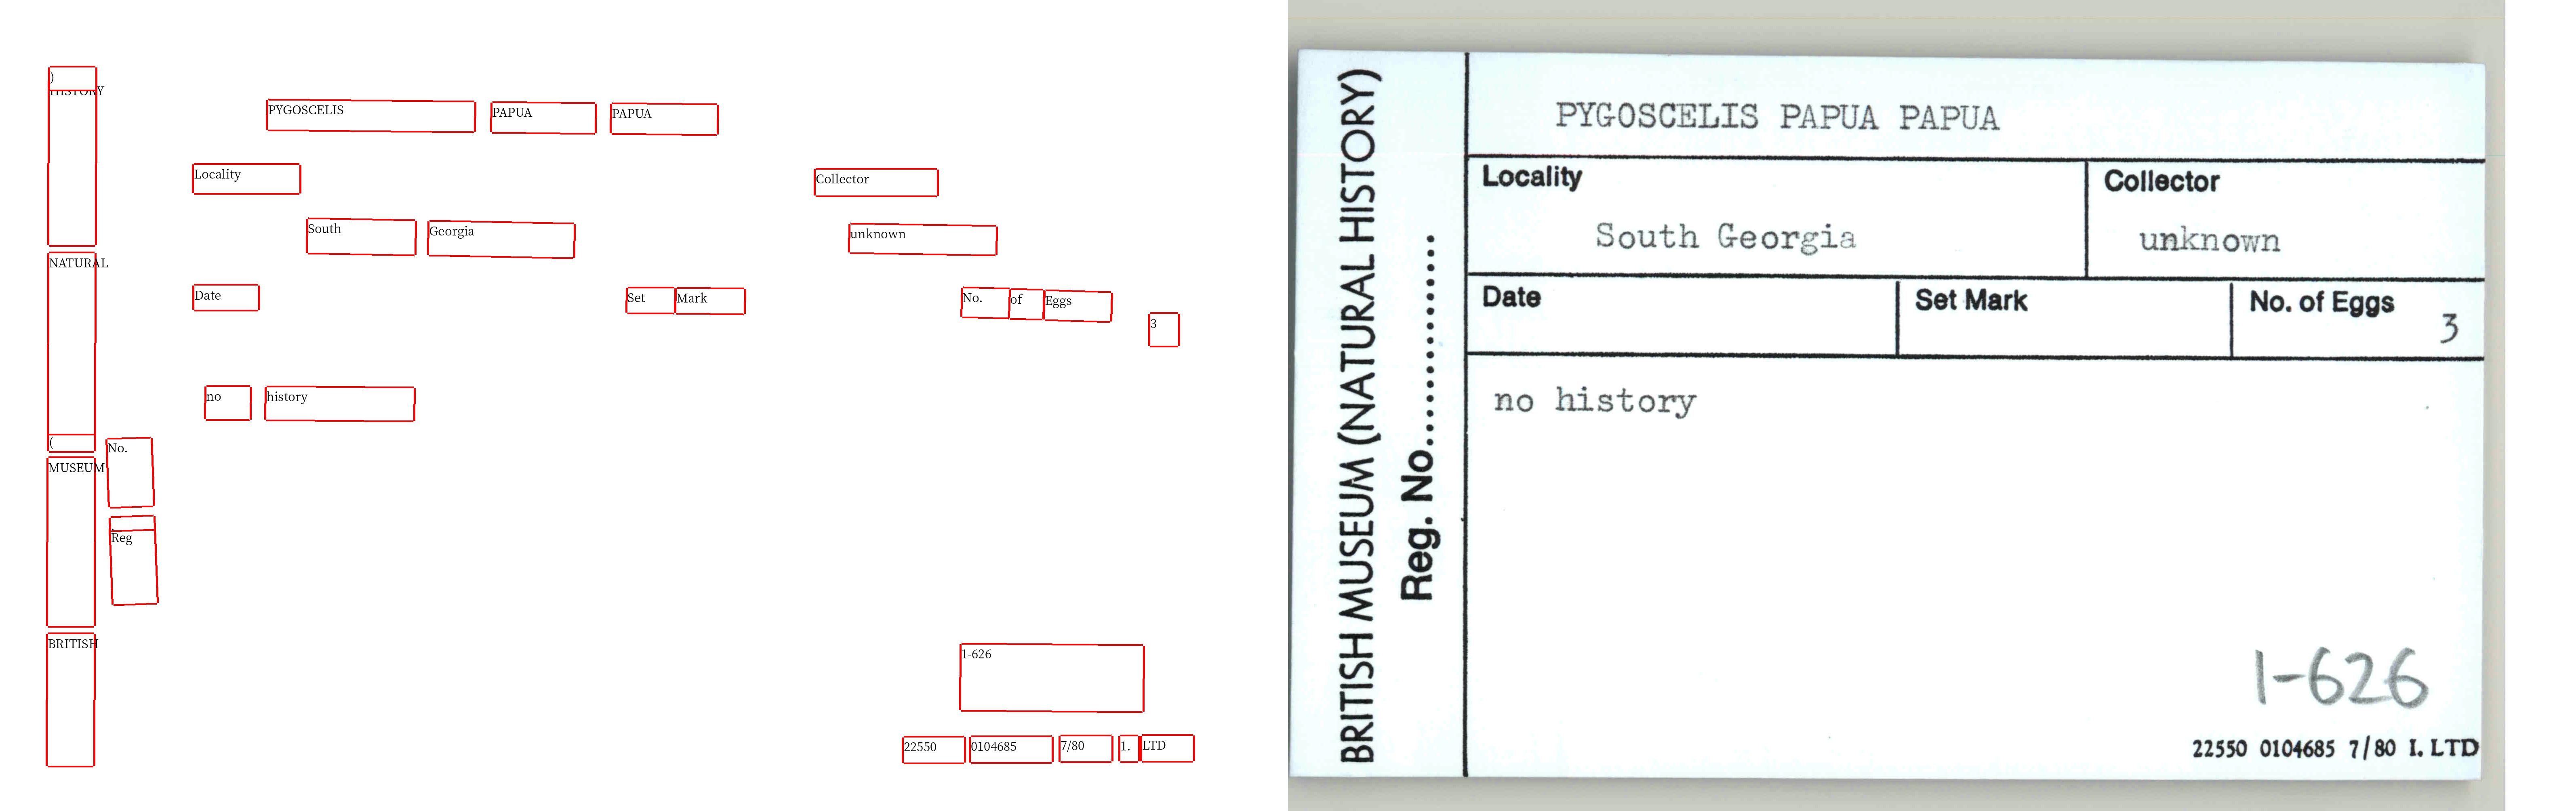

In [ ]:
lp.draw_text(image, layout, font_size=30, with_box_on_text=True,
             text_box_width=10)

In [ ]:
all_text = layout.get_texts()

In [ ]:
all_text

['BRITISH',
 'MUSEUM',
 '(',
 'NATURAL',
 'HISTORY',
 ')',
 'Reg',
 '.',
 'No.',
 'PYGOSCELIS',
 'PAPUA',
 'PAPUA',
 'Locality',
 'Date',
 'South',
 'Georgia',
 'no',
 'history',
 'Set',
 'Mark',
 'Collector',
 'unknown',
 'No.',
 'of',
 'Eggs',
 '3',
 '1-626',
 '22550',
 '0104685',
 '7/80',
 '1.',
 'LTD']